In [1]:
import sys

sys.path.insert(0, "..")
from src.settings import StyleSettings
from src.data.data_tools import StyleDataset
from src.models import rnn

import numpy as np
import seaborn as sns
from typing import Callable, Optional
from torchtext.vocab import Vocab


# Load the data

In [2]:
settings = StyleSettings()
traindataset = StyleDataset([settings.trainpath])
testdataset = StyleDataset([settings.testpath])


In [3]:
len(testdataset) //32

104

We have 419 batches in the dataset

In [4]:
len(traindataset) // 32


419

In [5]:
104+419

523

In [6]:
x, y = traindataset[42]
x, y


('Lace is an openwork fabric , patterned with open holes in the work , made by machine or by hand.',
 'wiki')

Every batch is a `Tuple[str, str]` of a sentence and a label. We can see this is a classification task.
The task is, to classify sentences in four categories.
Lets build a vocabulary by copy-pasting the code we used before

In [7]:
from src.models import tokenizer

corpus = []
for i in range(len(traindataset)):
    x = tokenizer.clean(traindataset[i][0])
    corpus.append(x)
v = tokenizer.build_vocab(corpus, max=20000)
len(v)


2022-06-19 12:45:58.559 | INFO     | src.models.tokenizer:build_vocab:27 - Found 19306 tokens


19308

We need to cast the labels to an integers. You can use this dictionary to do so:

In [8]:
d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
d[y]


2

# Question 1
Figure out, for every class, what accuracy you should expect if the model would guess blind on the train set

In [9]:
from collections import Counter

dataset = traindataset
list_labels = []
for i in range(len(dataset)):
    label = dataset[i][1]
    list_labels.append(label)

counter = Counter(list_labels)

for i in counter:
    accuracy = counter[i]/len(dataset)
    print("{}: {}".format(i, accuracy))

humor: 0.31414510476474533
wiki: 0.31175900380284843
proverbs: 0.06196405935426143
reuters: 0.3121318320781448


Reflect on what you see. What does this mean? What implications does this have? Why is that good/bad?
Are there things down the line that could cause a problem?

1. What does this mean?

The traindataset is unbalanced, where only one class (proverbs) has significantly less observations.

2. What implications does this have?

The model will have a hard time to learn to classify proverbs. 
A different metric/loss function is necessary to measure accuracy.

3. Why is this good/bad?



4. Things that could cause a problem down the line:

This dataset is not a balanced one, the category proverbs has significantly less observations available. The amount of observations in this class make up 6% of observations while the others all make up for around 31% of observations.


# Question 2 : Implement a preprocessor

We can inherit from `tokenizer.Preprocessor`
Only thing we need to adjust is the `cast_label` function.
 
- create a StylePreprocessor class
- inherit from Preprocessor
- create a new cast_label function for this dataset

In [10]:
# TODO ~ about 4 lines of code
class StylePreprocessor(tokenizer.Preprocessor):
    def __init__(self, max: int, vocab: Vocab, clean: Optional[Callable]) -> None:
        super().__init__(max, vocab, clean)

    def cast_label(self, label: str) -> int:
        d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
        return d[label]


To test the preprocessor:

In [11]:
preprocessor = StylePreprocessor(max=100, vocab=v, clean=tokenizer.clean)
preprocessor([(x, y)])


(tensor([[4929,  854,   32,   15,  499,   21, 8496,  890]], dtype=torch.int32),
 tensor([2]))

# Set up the model
We can re-use the BaseDatastreamer

In [12]:
from src.data import data_tools

trainstreamer = data_tools.BaseDatastreamer(
    dataset=traindataset, batchsize=32, preprocessor=preprocessor
).stream()
teststreamer = data_tools.BaseDatastreamer(
    dataset=testdataset, batchsize=32, preprocessor=preprocessor
).stream()


In [13]:
x, y = next(trainstreamer)
x.shape, y


(torch.Size([32, 39]),
 tensor([1, 1, 1, 3, 0, 0, 0, 3, 2, 2, 2, 1, 0, 0, 2, 1, 0, 0, 0, 3, 0, 0, 2, 2,
         1, 1, 0, 3, 1, 2, 0, 2]))

## Question 3 : Metrics, loss
Select proper metrics and a loss function.

Bonus: implement an additional metric function that is relevant for this case.

In [14]:
from src.models import metrics
import torch

# F1 score metric is good for unbalanced datasets (which we have), this measure combines precision and recall. 
# Accuracy metric is also loaded to compare 
metrics = [metrics.F1Score(), metrics.Accuracy()]
loss_fn = torch.nn.CrossEntropyLoss()
#torch.nn.NLLLoss
#torch.nn.KLDivLoss


## Question 4 : Basemodel
Create a base model. It does not need to be naive; you could re-use the
NLP models we used for the IMDB.

I suggest to start with a hidden size of about 128.
Use a config dictionary, or a gin file, both are fine.

Bonus points if you create a Trax model in src.models, and even more if you add a trax training loop.

In [15]:
from torchsummary import summary

log_dir = settings.log_dir
# TODO between 2 and 8 lines of code, depending on your setup
# Assuming you load your model in one line of code from src.models.rnn

config = {
    "vocab": len(v),
    "hidden_size": 128,
    "num_layers": 3,
    "dropout": 0.1,
    "output_size": 4,
}

model = rnn.NLPmodel(config)



Set up the trainloop.

- Give the lenght of the traindataset, how many batches of 32 can you get out of it?

419

- If you take a short amount of train_steps (eg 25) for every epoch, how many epochs do you need to cover the complete dataset?

There are 103 batches in testset, so 523 in entire dataset.
523/25 = 20.92 = 21

- What amount of epochs do you need to run the loop with trainsteps=25 to cover the complete traindataset once? 

419/25 = 16.76 = 17

- answer the questions above, and pick a reasonable epoch lenght

Start with a default learning_rate of 1e-3 and an Adam optimizer.

In [16]:
from src.training import train_model

model = train_model.trainloop(
    epochs=20,
    model=model,
    metrics=metrics,
    optimizer=torch.optim.Adam,
    learning_rate=1e-3,
    loss_fn=loss_fn,
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=25,
    eval_steps=25,
)


2022-06-19 12:46:29.550008: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-19 12:46:29.550039: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-19 12:46:31.555 | INFO     | src.data.data_tools:dir_add_timestamp:66 - Logging to ../tune/20220619-1246
100%|██████████| 25/25 [00:07<00:00,  3.52it/s]
2022-06-19 12:46:39.997 | INFO     | src.training.train_model:trainloop:164 - Epoch 0 train 1.3153 test 1.2536 metric ['0.2054', '0.3337']
100%|██████████| 25/25 [00:02<00:00, 10.81it/s]
2022-06-19 12:46:42.742 | INFO     | src.training.train_model:trainloop:164 - Epoch 1 train 1.2540 test 1.2132 metric ['0.2419', '0.4050']
100%|██████████| 25/25 [00:01<00:00, 16.10it/s]
2022-06-19 12:46:44.733 | INFO     | src.training.train_model:trainloop:164 -

Save an image from the training in tensorboard in the `figures` folder.
Explain what you are seeing.

ANSWER

After 20 epochs, the model is still learning, in both the test and train loss we can see that loss is still decreasing. For further tuning, the amount of epochs should increase. The model is learning more slowly than at the start though, perhaps we can implement step-wise decrease of the learning rate to keep speedy learning at the beginning and change to a lower learning rate once the learning slows down. 

There are two metrics taken into account, the f1 score and accuracy. We should look mostly at the F1-score as this metric is better adapted to unbalanced datasets. It is visible that accuracy score is indeed significantly higher. F1-score is up to around 75% after 20 epochs.

# 5 Evaluate the basemodel
Create a confusion matrix with the code below

[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'Target')]

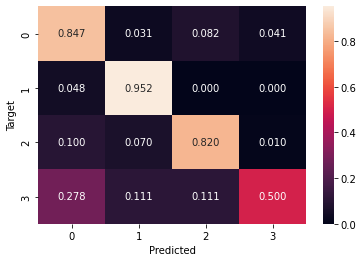

In [17]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for _ in range(10):
    X, y = next(teststreamer)
    yhat = model(X)
    yhat = yhat.argmax(dim=1)
    y_pred.append(yhat.tolist())
    y_true.append(y.tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
plot = sns.heatmap(cfm_norm, annot=cfm_norm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")


Save this in the figures folder.
Interpret this. 

- What is going on?
- What is a good metric here?
- how is your answer to Q1 relevant here?
- Is there something you could do to fix/improve things, after you see these results?

# 6 Tune the model
Don't overdo this.
More is not better.

Bonus points for things like:
- Attention layers
- Trax architecture including a functioning training loop

Keep it small! It's better to present 2 or 3 sane experiments that are structured and thought trough, than 25 random guesses. You can test more, but select 2 or 3 of the best alternatives you researched, with a rationale why this works better.

Keep it concise; explain:
- what you changed
- why you thought that was a good idea  
- what the impact was (visualise or numeric)
- explain the impact

You dont need to get a perfect score; curiousity driven research that fails is fine.
The insight into what is happening is more important than the quantity.

Keep logs of your settings;
either use gin, or save configs, or both :)
Store images in the `figures` folder.